In [27]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSBB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [28]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [29]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


C:\Users\Sai\.conda\envs\python2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['interactive', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [32]:
data_dir='../../Data/Weather'
file_index='SSSBSSBB'

In [33]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [34]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1219.2|   37.75|  -117.65|       PRCP|USC00267465|    31|[00 00 00 00 00 0...|1898.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       PRCP|USC00045352|     0|[00 00 00 00 00 0...|1985.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       PRCP|USC00045352|    33|[00 00 00 00 00 4...|1986.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       PRCP|USC00045352|    33|[00 00 20 51 00 0...|1988.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       PRCP|USC00045352|     0|[00 00 00 00 00 0...|1989.0|SSSBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [35]:
#rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
dfnew=df.limit(1)
rows2=dfnew.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
t2=np.vstack(rows2)
print type(t2)
s=nansum(t2,axis=1)
s
#T=np.vstack(rows)
#shape(T)

<type 'numpy.ndarray'>


array([ 864.], dtype=float16)

In [36]:
print type(t2)
s=nansum(t2,axis=1)
s

<type 'numpy.ndarray'>


array([ 864.], dtype=float16)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

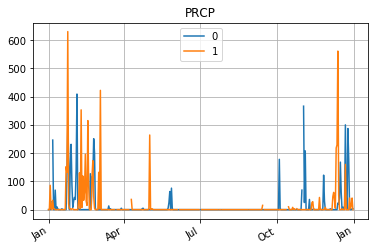

In [37]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

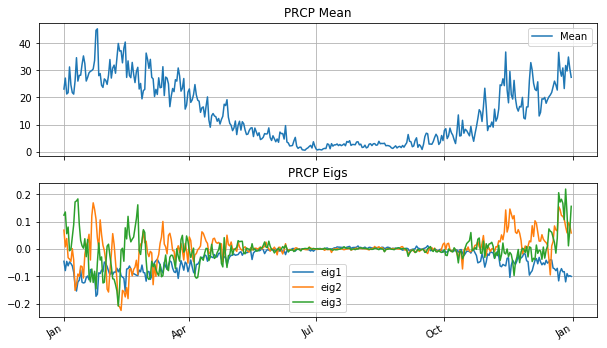

In [38]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

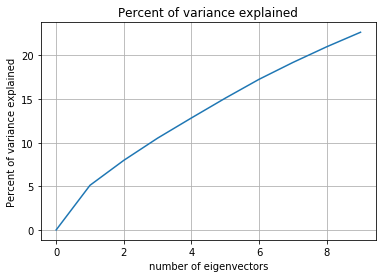

In [39]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [40]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.905519101926
residual normalized norm  after mean + top eigs: [ 0.9971826   0.92984536  0.92976733]


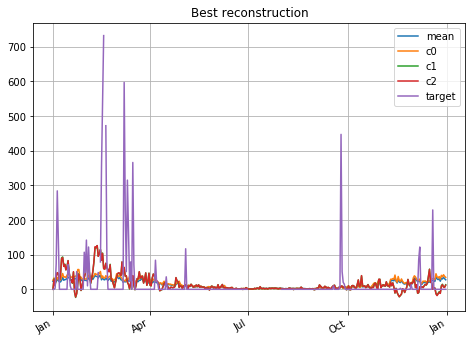

The installed widget Javascript is the wrong version.


In [41]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [16]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

TypeError: decompose() takes exactly 1 argument (3 given)

In [42]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [53]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2750
after filter 1957


In [44]:
#df3=df3.sort(df3.res_3,ascending=True)
#rows=df3.take(12)


In [45]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [100]:
df4=df3.sort(df3.coeff_1)
rows=df4.take(100)
dfrows2=df4.limit(100)
rows2=dfrows2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
c1mat1=dfrows2.rdd.map(lambda row:row['coeff_1']).collect()

t=np.vstack(rows2)
s1= list(nansum(t,axis=1))
print s                    
df4.select('res_mean','res_1','res_2','res_3').show(4)

[19632.0, 17216.0, 13640.0, 16816.0, 15840.0, 14472.0, 13832.0, 15200.0, 12568.0, 15992.0, 14992.0, 14784.0]
+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.8946025645454766|0.8435399291879508|0.7424992210436744|0.7245887961070919|
|0.8713880119437531|0.8272398941660155|0.7432688005727334|0.6915294988780233|
|0.8803518652730052|0.8356071125553364|0.8350360912891921|0.6027694890482412|
|0.8730065077650895|0.8371828324545394|0.7446148826792065|0.6852682085811107|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



In [65]:
c1mat

[(-980.9187195395816, numpy.float16),
 (-890.570206312235, numpy.float16),
 (-856.6292675760533, numpy.float16),
 (-854.9515109788501, numpy.float16),
 (-853.1647406966197, numpy.float16),
 (-848.0611769678314, numpy.float16),
 (-825.1382116952625, numpy.float16),
 (-789.9583809360829, numpy.float16),
 (-777.42392258805, numpy.float16),
 (-751.5820748556021, numpy.float16),
 (-743.7679569841621, numpy.float16),
 (-731.3911480870099, numpy.float16)]

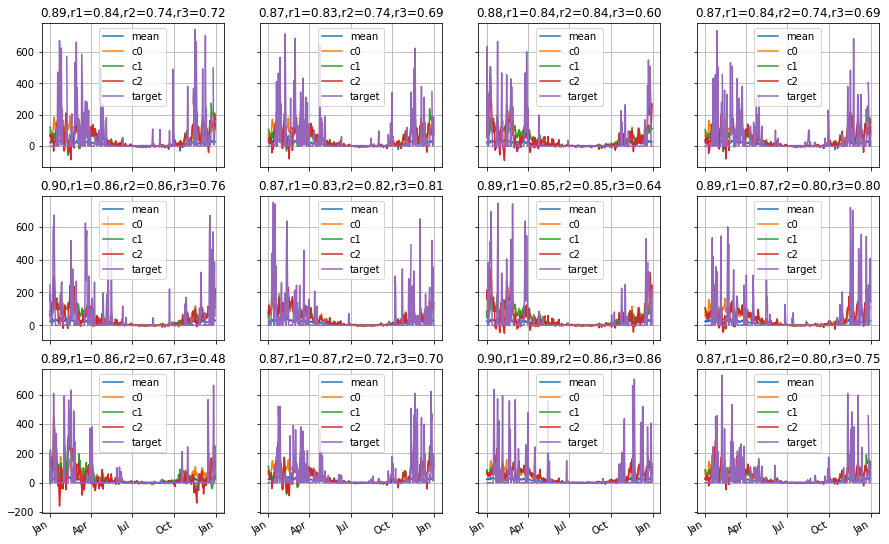

In [59]:
plot_recon_grid(rows)

In [101]:
df5=df3.sort(df3.coeff_1,ascending=False)
rows=df5.take(100)
dfrows2=df5.limit(100)
rows2=dfrows2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
c1mat2=dfrows2.rdd.map(lambda row:row['coeff_1']).collect()
t=np.vstack(rows2)
s2=list(nansum(t,axis=1))
df5.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.9932429837461855|0.9243887786570885|0.9238046685463871| 0.876994104006874|
| 0.988472123373827|0.8876475325028417|0.8548711098841122|0.8539635427153809|
| 0.999048345964197|0.9538797275440546|0.9538978017510334|0.9459061154019744|
|0.9962018331866719|0.9483185467800345|0.9292445404493498|0.9247258551579624|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



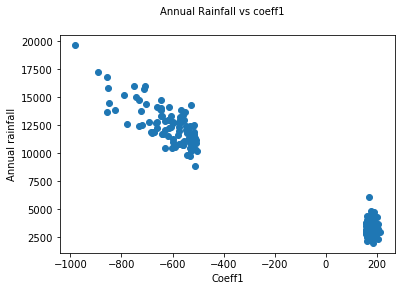

In [102]:
st=s1+s2
st
ct=c1mat1+c1mat2

from matplotlib import pyplot as plt    

fig = plt.figure()
plt.scatter(ct,st)
fig.suptitle('Annual Rainfall vs coeff1', fontsize=10)
plt.xlabel('Coeff1', fontsize=10)
plt.ylabel('Annual rainfall', fontsize=10)
fig.savefig('test.jpg')

#matplotlib.pyplot.scatter(st,ct)

#matplotlib.pyplot.show()

In [103]:
np.corrcoef(st,ct)

array([[ 1.        , -0.98025357],
       [-0.98025357,  1.        ]])

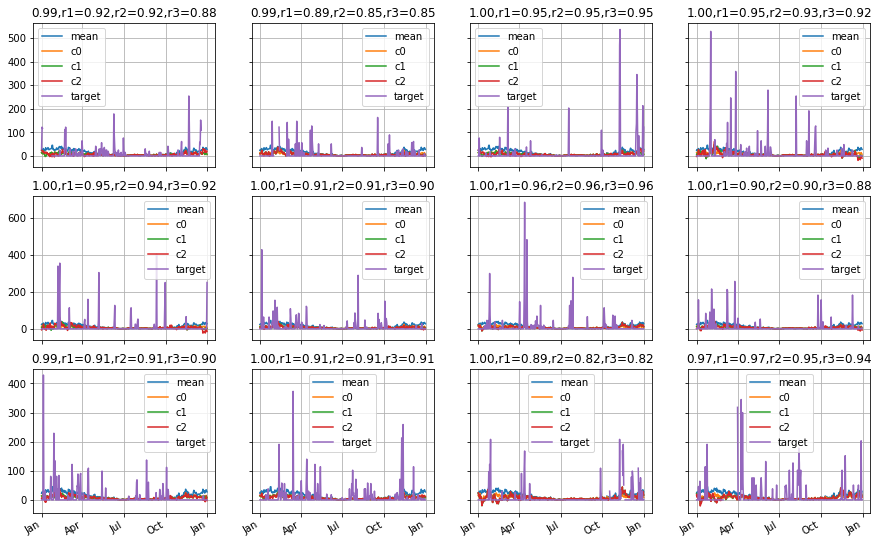

In [61]:
plot_recon_grid(rows)

In [82]:
annualrain=df3.rdd.map(lambda row:nansum(unpackArray(row['vector'],np.float16))).collect()
elevation=df3.rdd.map(lambda row:row['elevation']).collect()
#t=np.vstack(rows2)
#s2=list(nansum(t,axis=1))
#df5.select('res_mean','res_1','res_2','res_3').show(4)
annualrain

[5784.0,
 6652.0,
 6000.0,
 5580.0,
 4840.0,
 9512.0,
 6196.0,
 11728.0,
 5584.0,
 8180.0,
 7356.0,
 8024.0,
 10320.0,
 5616.0,
 4968.0,
 5336.0,
 5280.0,
 3804.0,
 4500.0,
 4972.0,
 9160.0,
 6728.0,
 5132.0,
 8400.0,
 5224.0,
 6928.0,
 6512.0,
 7764.0,
 5480.0,
 4496.0,
 5564.0,
 8496.0,
 6516.0,
 7244.0,
 5964.0,
 8256.0,
 8752.0,
 6368.0,
 8264.0,
 4868.0,
 10632.0,
 10336.0,
 7592.0,
 7608.0,
 8976.0,
 8808.0,
 6956.0,
 3748.0,
 6480.0,
 6116.0,
 8336.0,
 7512.0,
 9256.0,
 4924.0,
 7776.0,
 8344.0,
 6208.0,
 8888.0,
 9584.0,
 4192.0,
 6800.0,
 5216.0,
 12088.0,
 4288.0,
 8504.0,
 12544.0,
 11632.0,
 9776.0,
 9976.0,
 13416.0,
 16816.0,
 7056.0,
 8752.0,
 8664.0,
 8352.0,
 6784.0,
 5432.0,
 6904.0,
 8984.0,
 11472.0,
 10024.0,
 14408.0,
 6100.0,
 15712.0,
 8020.0,
 9328.0,
 10800.0,
 8020.0,
 8704.0,
 8712.0,
 13304.0,
 12608.0,
 4576.0,
 8856.0,
 8040.0,
 13416.0,
 9328.0,
 8424.0,
 9608.0,
 7328.0,
 6456.0,
 11632.0,
 11536.0,
 4280.0,
 4896.0,
 6392.0,
 4944.0,
 5160.0,
 3416.0,


In [94]:
dic={}

for x,y in zip(annualrain,elevation):
    dic.setdefault(y,[]).append(x) 
    


In [95]:
for key in dic.keys():
    dic[key]=sum(list(np.array(dic[key])/len(dic[key])))

In [96]:
keys, values = zip(*dic.items())

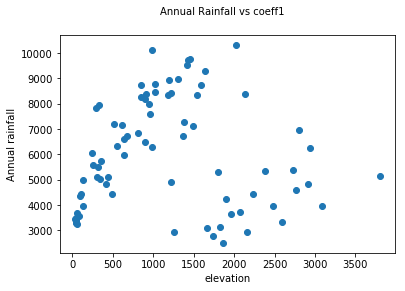

In [97]:
from matplotlib import pyplot as plt    

fig = plt.figure()
plt.scatter(keys,values)
fig.suptitle('Annual Rainfall vs coeff1', fontsize=10)
plt.xlabel('elevation', fontsize=10)
plt.ylabel('Annual rainfall', fontsize=10)
fig.savefig('test.jpg')

In [98]:
np.corrcoef(keys,values)

array([[ 1.        ,  0.01663051],
       [ 0.01663051,  1.        ]])

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

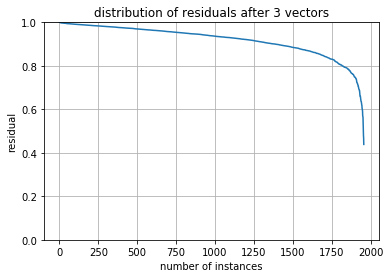

In [24]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [25]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [26]:
!du -sh $data_dir/*.parquet

4.7M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.7M	../../Data/Weather/US_Weather_SSSBSSBB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.2M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.2M	../../Data/Weather/decon_SSSBSSBB_PRCP.parquet
2.4M	../../Data/Weather/decon_SSSBSSBB_SNWD.parquet
3.2M	../../Data/Weather/decon_SSSBSSBB_TOBStobsc3.parquet
